# 8. DQN 改进算法

## 8.1 简介
- DQN 算法敲开了深度强化学习的大门，但是作为先驱性的工作，其本身存在着一些问题以及一些可以改进的地方。于是，在 DQN 之后，学术界涌现出了非常多的改进算法。本章将介绍其中两个非常著名的算法：Double DQN 和 Dueling DQN，这两个算法的实现非常简单，只需要在 DQN 的基础上稍加修改，它们能在一定程度上改善 DQN 的效果。如果读者想要了解更多、更详细的 DQN 改进方法，可以阅读 Rainbow 模型的论文及其引用文献。

## 8.2 Double DQN
- 普通的 DQN 算法通常会导致对 $Q$ 值的过高估计（overestimation）。传统 DQN 优化的 TD 误差目标为：

$$
r + \gamma \max_{a'}Q_{\omega^-}(s',a')
$$

- 其中 $\max_{a'}Q_{\omega^-}(s',a')$ 由目标网络（参数为 $\omega^-$）计算得出，我们还可以将其写成如下形式：

$$
Q_{\omega^-}\left(s^{\prime},\arg\max_{a^{\prime}}Q_{\omega^-}\left(s^{\prime},a^{\prime}\right)\right)
$$

- 换句话说，$\max$ 操作实际可以被拆解为两部分：首先选取状态 $s'$ 下的最优动作 $a^{*}=\arg\max_{a^{\prime}}Q_{\omega^{-}}(s^{\prime},a^{\prime})$，接着计算该动作对应的价值 $Q_{\omega^{-}}(s^{\prime},a^{*})$。当这两部分采用同一套 $Q$ 网络进行计算时，每次得到的都是神经网络当前估算的所有动作价值中的最大值。考虑到通过神经网络估算的 $Q$ 值本身在某些时候会产生正向或负向的误差，在 DQN 的更新方式下神经网络会将正向误差累积。例如，我们考虑一个特殊情形：在状态 $s'$ 下所有动作的 $Q$ 值均为 0，即 $Q(s^{\prime},a_{i})=0,\forall i$，此时正确的更新目标应为 $r + 0 = r$，但是由于神经网络拟合的误差通常会出现某些动作的估算有正误差的情况，即存在某个动作 $a'$ 有 $Q(s',a') > 0$，此时我们的更新目标出现了过高估计，$r+\gamma\max Q>r+0$。因此，当我们用 DQN 的更新公式进行更新时，$Q(s,a)$ 也就会被过高估计了。同理，我们拿这个 $Q(s, a)$ 来作为更新目标来更新上一步的 $Q$ 值时，同样会过高估计，这样的误差将会逐步累积。对于动作空间较大的任务，DQN 中的过高估计问题会非常严重，造成 DQN 无法有效工作的后果。

- 为了解决这一问题，Double DQN 算法提出利用两个独立训练的神经网络估算 $max_{a'}Q_*(s',a')$。具体做法是将原有的 $\max_{a^{\prime}}Q_{\omega^{-}}(s^{\prime},a^{\prime})$ 更改为 $Q_{\omega^{-}}(s^{\prime},\arg\max_{a^{\prime}}Q_{\omega}\left(s^{\prime},a^{\prime}\right))$，即利用一套神经网络 $Q_{\omega}$ 的输出选取价值最大的动作，但在使用该动作的价值时，用另一套神经网络 $Q_{\omega}^-$ 计算该动作的价值。这样，即使其中一套神经网络的某个动作存在比较严重的过高估计问题，由于另一套神经网络的存在，这个动作最终使用的 $Q$ 值不会存在很大的过高估计问题。

- 在传统的 DQN 算法中，本来就存在两套 $Q$ 函数的神经网络——目标网络和训练网络（参见 7.3.2 节），只不过 $max_{a'}Q_{\omega^-}(s',a')$ 的计算只用到了其中的目标网络，那么我们恰好可以直接将训练网络作为 Double DQN 算法中的第一套神经网络来选取动作，将目标网络作为第二套神经网络计算 $Q$ 值，这便是 Double DQN 的主要思想。由于在 DQN 算法中将训练网络的参数记为 $\omega$，将目标网络的参数记为 $\omega^-$，这与本节中 Double DQN 的两套神经网络的参数是统一的，因此，我们可以直接写出如下 Double DQN 的优化目标：

$$
r+\gamma Q_{\omega^-}\left(s^{\prime},\arg\max_{a^{\prime}}Q_\omega\left(s^{\prime},a^{\prime}\right)\right)
$$

## 8.3 Double DQN 代码实践
- 显然，DQN 与 Double DQN 的差别只是在于计算状态 $s'$ 下 $Q$ 值时如何选取动作：
    - DQN 的优化目标可以写为 $r+\gamma Q_{\omega^{-}}\left(s^{\prime},\arg\max_{a^{\prime}}Q_{\omega^{-}}\left(s^{\prime},a^{\prime}\right)\right)$，动作选取依靠目标网络 $Q_{\omega^-}$
    - Double DQN 的优化目标为 $r+\gamma Q_{\omega^{-}}\left(s^{\prime},\arg\max_{a^{\prime}}Q_{\omega}\left(s^{\prime},a^{\prime}\right)\right)$，动作选取依靠目标网络 $Q_{\omega}$

- 所以 Double DQN 的代码实现可以直接在 DQN 的基础上进行，无须做过多修改。

- 本节采用的环境是倒立摆（Inverted Pendulum），该环境下有一个处于随机位置的倒立摆，如图 8-1 所示。环境的状态包括倒立摆角度的正弦值 $\sin{\theta}$，余弦值 $\cos{\theta}$，角速度 $\theta$；动作为对倒立摆施加的力矩，详情参见表 8-1 和表 8-2。每一步都会根据当前倒立摆的状态的好坏给予智能体不同的奖励，该环境的奖励函数为 $-(\theta^2+0.1\dot{\theta}^2+0.001a^2)$，倒立摆向上保持直立不动时奖励为 0，倒立摆在其他位置时奖励为负数。环境本身没有终止状态，运行 200 步后游戏自动结束。

<div align="center">
    <img src="./image/8-1.gif">
    <center>图 8-1 Pendulum环境示意图</center>
</div>

| 标号 | 名称         | 最小值 | 最大值 |
|------|--------------|--------|--------|
| 0    | \cos{\theta} | -1.0   | 1.0    |
| 1    | \sin{\theta} | -1.0   | 1.0    |
| 2    | \theta     | -8.0   | 8.0    |

<center>表8-1 Pendulum环境的状态空间</center>


| 标号 | 动作 | 最小值 | 最大值 |
|------|------|--------|--------|
| 0    | 力矩 | -2.0   | 2.0    |

<center>表8-2 Pendulum环境的动作空间</center>

- 力矩大小是在 $[-2,2]$，由于 DQN 只能处理离散动作环境，因此我们无法直接用 DQN 来处理倒立摆环境，但倒立摆环境可以比较方便地验证 DQN 对 $Q$ 值的过高估计：倒立摆环境下 $Q$ 值的最大估计应该是 0（倒立摆向上保持直立时能选取的最大 $Q$ 值），$Q$ 值出现大于 0 的情况则说明出现了过高估计。为了能够应用 DQN，我们采用离散化动作的技巧。例如，下面的代码将连续的动作空间离散为 11 个动作。动作 $[0,1,2,...,9,10]$ 分别代表力矩为 $[-2, -1.6, -1.2, ..., 1.2, 1.6, 2]$

In [1]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm


class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

- 接下来我们在 DQN 代码的基础上稍做修改以实现 Double DQN。

In [4]:
class DQN:
    ''' DQN算法,包括Double DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else: # DQN的情况
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

- 接下来我们设置相应的超参数，并实现将倒立摆环境中的连续动作转化为离散动作的函数。

In [6]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作


def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action /
                              (action_dim - 1)) * (action_upbound -
                                                   action_lowbound)

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


- 接下来要对比 DQN 和 Double DQN 的训练情况，为了便于后续多次调用，我们进一步将 DQN 算法的训练过程定义成一个函数。训练过程会记录下每个状态的最大值，在训练完成后我们可以将结果可视化，观测这些 $Q$ 值存在的过高估计的情况，以此来对比 DQN 和 Double DQN 的不同。

In [7]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(
                        state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env,
                                                   agent.action_dim)
                    next_state, reward, done, _ = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

- 一切就绪！我们首先训练 DQN 并打印出其学习过程中最大 $Q$ 值的情况。

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_2893731/2173894099.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it, episode=200, return=-332.256]


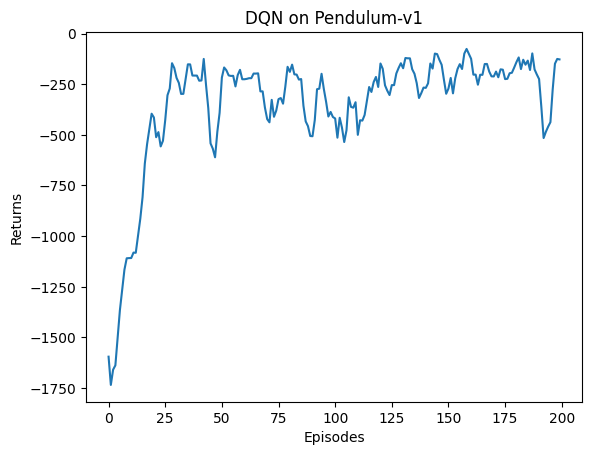

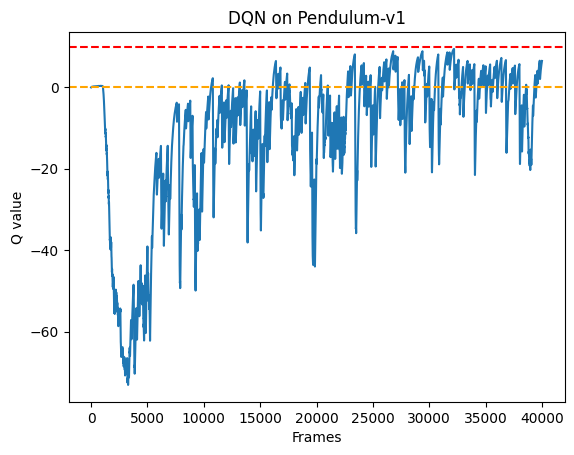

In [8]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

- 根据代码运行结果我们可以发现，DQN 算法在倒立摆环境中能取得不错的回报，最后的期望回报在-200 左右，但是不少 $Q$ 值超过了 0，有一些还超过了 10，该现象便是 DQN 算法中的 $Q$ 值过高估计。我们现在来看一下 Double DQN 是否能对此问题进行改善。

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Iteration 9: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it, episode=200, return=-314.952]


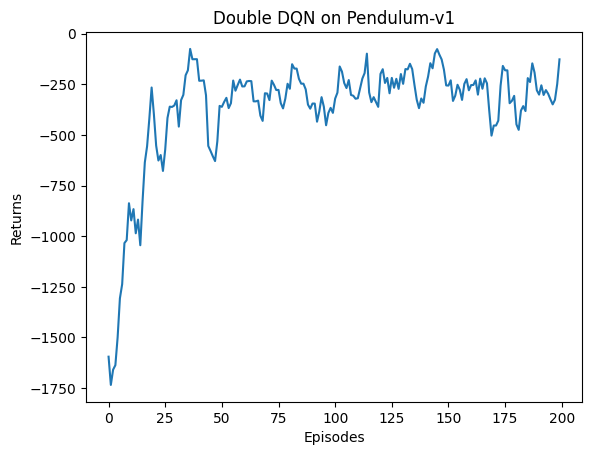

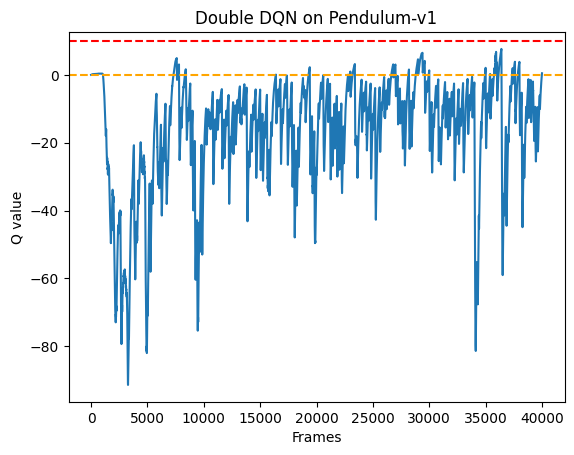

In [9]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

- 我们可以发现，与普通的 DQN 相比，Double DQN 比较少出现 $Q$ 值大于 0 的情况，说明 $Q$ 值过高估计的问题得到了很大缓解。

## 8.4 Dueling DQN
- Dueling DQN 是 DQN 另一种的改进算法，它在传统 DQN 的基础上只进行了微小的改动，但却能大幅提升 DQN 的表现。在强化学习中，我们将状态动作价值函数 $Q$ 减去状态价值函数 $V$ 的结果定义为优势函数 $A$，即 $A(s,a) = Q(s,a) - V(s)$。 在同一个状态下，所有动作的优势值之和为 0，因为所有动作的动作价值的期望就是这个状态的状态价值。据此，在 Dueling DQN 中，Q 网络被建模为：

$$
Q_{\eta,\alpha,\beta}(s,a)=V_{\eta,\alpha}(s)+A_{\eta,\beta}(s,a)
$$

其中，$V_{\eta,\alpha}(s)$ 为状态价值函数，而 $A_{\eta,\beta}(s,a)$ 则为该状态下采取不同动作的优势函数，表示采取不同动作的差异性；$\eta$ 是状态价值函数和优势函数共享的网络参数，一般用在神经网络中，用来提取特征的前几层；而 $\alpha$ 和 $\beta$ 分别为状态价值函数和优势函数的参数。在这样的模型下，我们不再让神经网络直接输出 $Q$ 值，而是训练神经网络的最后几层的两个分支，分别输出状态价值函数和优势函数，再求和得到 $Q$ 值。Dueling DQN 的网络结构如图 8-2 所示。

<div align="center">
    <img src="./image/8-2.png">
    <center>图 8-2 Dueling DQN的网络结构图</center>
</div>

- 将状态价值函数和优势函数分别建模的好处在于：某些情境下智能体只会关注状态的价值，而并不关心不同动作导致的差异，此时将二者分开建模能够使智能体更好地处理与动作关联较小的状态。在图 8-3 所示的驾驶车辆游戏中，智能体注意力集中的部位被显示为橙色（另见彩插图 4），当智能体前面没有车时，车辆自身动作并没有太大差异，此时智能体更关注状态价值，而当智能体前面有车时（智能体需要超车），智能体开始关注不同动作优势值的差异。

<div align="center">
    <img src="./image/8-3.png">
    <center>图 8-3 状态价值和优势值的简单例子</center>
</div>

- 对于 Dueling DQN 中的公式 $Q_{\eta,\alpha,\beta}(s,a)=V_{\eta,\alpha}(s)+A_{\eta,\beta}(s,a)$，它存在对于 $V$ 值和 $A$ 值建模不唯一性的问题。例如，对于同样的 $Q$ 值，如果将 $V$ 值加上任意大小的常数 $C$，再将所有 $A$ 值减去 $C$，得到的 $Q$ 值依然不变，这就导致了训练的不稳定性。为了解决这一问题，Dueling DQN 强制最优动作的优势函数的实际输出为 0，即：

$$
Q_{\eta,\alpha,\beta}(s,a)=V_{\eta,\alpha}(s)+A_{\eta,\beta}(s,a)-\max_{a^{\prime}}A_{\eta,\beta}\left(s,a^{\prime}\right)
$$

- 此时 $V(s) = max_aQ(s,a)$，可以确保 $V$ 值建模的唯一性。在实现过程中，我们还可以用平均代替最大化操作，即：

$$
Q_{\eta,\alpha,\beta}(s,a)=V_{\eta,\alpha}(s)+A_{\eta,\beta}(s,a)-\frac{1}{|\mathcal{A}|}\sum_{a^{\prime}}A_{\eta,\beta}\left(s,a^{\prime}\right)
$$

- 此时 $V(s)=\frac{1}{|\mathcal{A}|}\sum_{a^{\prime}}Q(s,a^{\prime})$。在下面的代码实现中，我们将采取此种方式，虽然它不再满足贝尔曼最优方程，但实际应用时更加稳定。

- 有的读者可能会问：“为什么 Dueling DQN 会比 DQN 好？”部分原因在于 Dueling DQN 能更高效学习状态价值函数。每一次更新时，函数 $V$ 都会被更新，这也会影响到其他动作的 $Q$ 值。而传统的 DQN 只会更新某个动作的 $Q$ 值，其他动作的 $Q$ 值就不会更新。因此，Dueling DQN 能够更加频繁、准确地学习状态价值函数。

## Dueling DQN 代码实践
- Dueling DQN 与 DQN 相比的差异只是在网络结构上，大部分代码依然可以继续沿用。我们定义状态价值函数和优势函数的复合神经网络 `VAnet`。

Iteration 9: 100%|██████████| 20/20 [00:41<00:00,  2.07s/it, episode=200, return=-209.006]


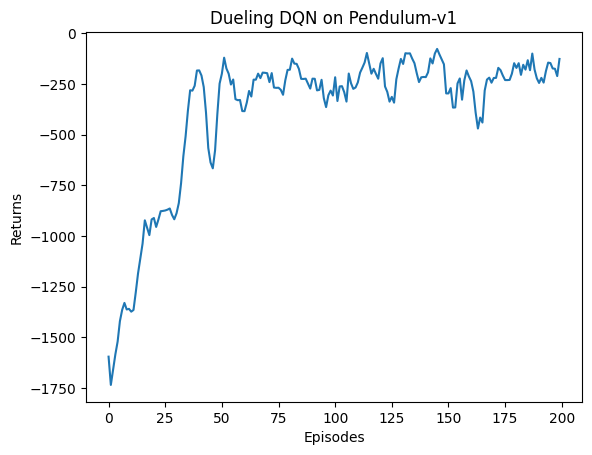

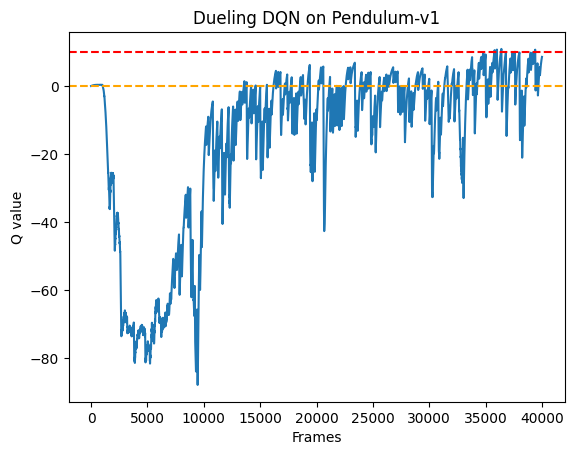

In [10]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q


class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
                -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

- 根据代码运行结果我们可以发现，相比于传统的 DQN，Dueling DQN 在多个动作选择下的学习更加稳定，得到的回报最大值也更大。由 Dueling DQN 的原理可知，随着动作空间的增大，Dueling DQN 相比于 DQN 的优势更为明显。之前我们在环境中设置的离散动作数为 11，我们可以增加离散动作数（例如 15、25 等），继续进行对比实验。

## 8.6 总结
- 在传统的 DQN 基础上，有两种非常容易实现的变式——Double DQN 和 Dueling DQN，Double DQN 解决了 DQN 中对 $Q$ 值的过高估计，而 Dueling DQN 能够很好地学习到不同动作的差异性，在动作空间较大的环境下非常有效。从 Double DQN 和 Dueling DQN 的方法原理中，我们也能感受到深度强化学习的研究是在关注深度学习和强化学习有效结合：一是在深度学习的模块的基础上，强化学习方法如何更加有效地工作，并避免深度模型学习行为带来的一些问题，例如使用 Double DQN 解决 $Q$ 值过高估计的问题；二是在强化学习的场景下，深度学习模型如何有效学习到有用的模式，例如设计 Dueling DQN 网络架构来高效地学习状态价值函数以及动作优势函数。

## 8.7 扩展阅读：对 Q 值过高估计的定量分析
- 我们可以对 $Q$ 值的过高估计做简化的定量分析。假设在状态 $s$ 下所有动作的期望回报均无差异，即 $Q^*(s,a) = V^*(s)$（此设置是为了定量分析所简化的情形，实际上不同动作的期望回报通常会存在差异）；假设神经网络估算误差 $Q_{\omega^{-}}(s,a)-V^{*}$ 服从 $[-1,1]$ 之间的均匀独立同分布；假设动作空间大小为 $m$。那么，对于任意状态 $s$，有：

$$
\mathbb{E}\left[\max_aQ_{\omega^-}(s,a)-\max_{a^{\prime}}Q_*(s,a^{\prime})\right]=\frac{m-1}{m+1}
$$

- 即动作空间越大时，$Q$ 值过高估计越严重。
- **证明：**将估算误差记为 $\epsilon_{a}=Q_{\omega^{-}}(s,a)-\max_{a^{\prime}}Q^{*}(s,a^{\prime})$，由于估算误差对于不同的动作是独立的，因此有：

$$
P\left(\max_a\epsilon_a\leq x\right)=\prod_{a=1}^mP\left(\epsilon_a\leq x\right)
$$

- $P(\epsilon_a \le x)$ 是 $\epsilon_a$ 的**累积分布函数**（cumulative distribution function，即 CDF），它可以具体被写为：

$$
P\left(\epsilon_{a}\leq x\right)=
\begin{cases}
0 & \mathrm{if}x\leq-1 \\
\frac{1+x}{2} & \mathrm{if}x\in(-1,1) \\
1 & \mathrm{if}x\geq1 & 
\end{cases}
$$

- 因此，我们得到关于 $\max_a \epsilon_a$ 的累积分布函数：

$$
\begin{aligned}
P\left(\max_{a}\epsilon_{a}\leq x\right) & =\prod_{a=1}^mP\left(\epsilon_a\leq x\right) \\
 & =
\begin{cases}
0 & \mathrm{if}x\leq-1 \\
\left(\frac{1+x}{2}\right)^m & \mathrm{if}x\in(-1,1) \\
1 & \mathrm{if}x\geq1 & 
\end{cases}
\end{aligned}
$$

- 最后，我们可以得到：

$$
\begin{aligned}
\mathbb{E}\left[\max_a\epsilon_a\right] & =\int_{-1}^1x\frac{\mathrm{d}}{\mathrm{d}x}P\left(\max_a\epsilon_a\leq x\right)\mathrm{d}x \\
 & =\left[\left(\frac{x+1}{2}\right)^m\frac{mx-1}{m+1}\right]_{-1}^1 \\
 & =\frac{m-1}{m+1}
\end{aligned}
$$

- 虽然这一分析简化了实际环境，但它仍然正确刻画了 $Q$ 值过高估计的一些性质，比如 $Q$ 值的过高估计随动作空间大小 $m$ 的增加而增加，换言之，在动作选择数更多的环境中，$Q$ 值的过高估计会更严重。